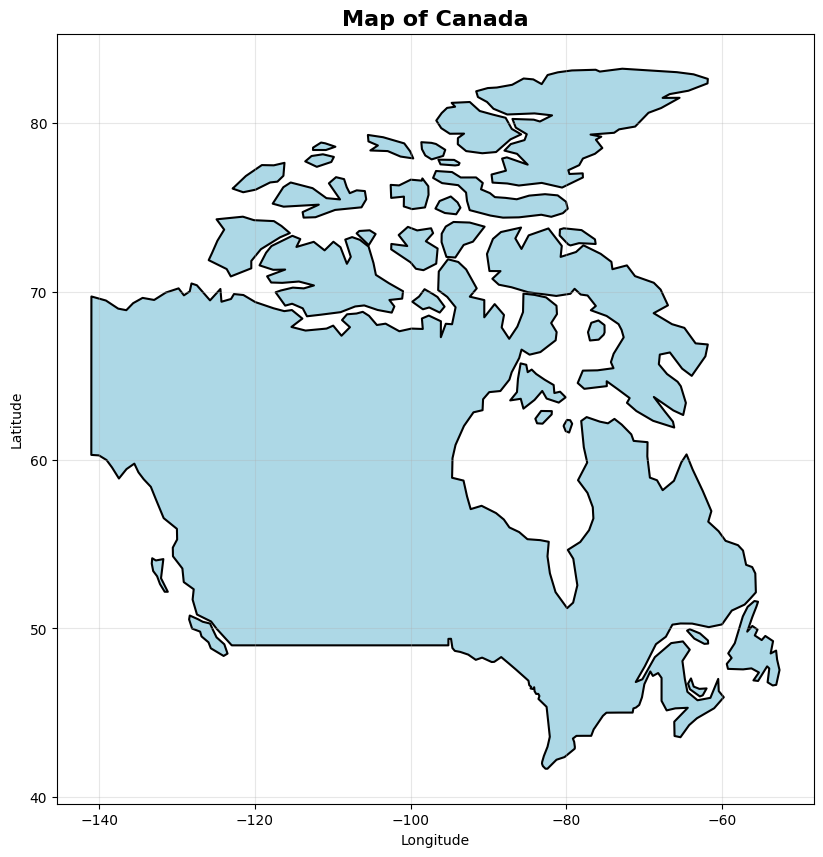

Canada bounds: [-140.99778      41.67510509  -52.64809872   83.23324   ]
Canada area: 1713.00


/tmp/ipykernel_61617/2448316934.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Canada area: {canada.area.values[0]:.2f}")


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load world map (GeoPandas built-in datasets were removed in v1.0)
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)

# Filter for Canada
name_col = "name" if "name" in world.columns else "ADMIN"
canada = world[world[name_col] == "Canada"]

# Plot Canada
fig, ax = plt.subplots(figsize=(10, 10))
canada.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=1.5)
ax.set_title("Map of Canada", fontsize=16, fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.3)
plt.show()

# Print some info
print(f"Canada bounds: {canada.bounds.values[0]}")
print(f"Canada area: {canada.area.values[0]:.2f}")

Matrix shape: (200, 200)
Top-left 10x10 block:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


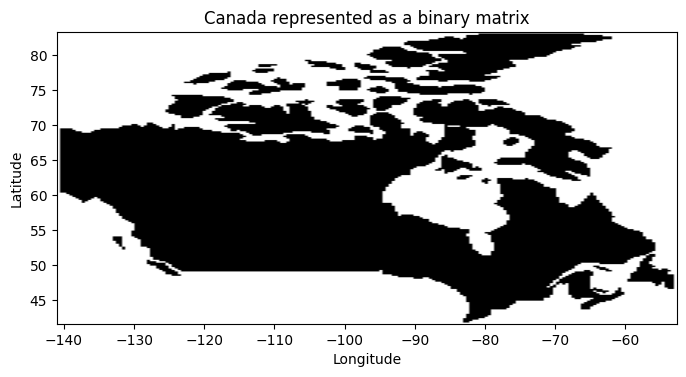

In [2]:
import numpy as np
from shapely import contains_xy

# Merge Canada geometry to a single shape
canada_geom = canada.geometry.union_all()

# Build a binary matrix over the bounding box
minx, miny, maxx, maxy = canada_geom.bounds
n_rows, n_cols = 200, 200
xs = np.linspace(minx, maxx, n_cols)
ys = np.linspace(miny, maxy, n_rows)
X, Y = np.meshgrid(xs, ys)

canada_matrix = contains_xy(canada_geom, X, Y).astype(np.uint8)

print(f"Matrix shape: {canada_matrix.shape}")
print("Top-left 10x10 block:\n", canada_matrix[:10, :10])

plt.figure(figsize=(8, 8))
plt.imshow(
    canada_matrix,
    origin="lower",
    cmap="gray_r",
    extent=[minx, maxx, miny, maxy],
    aspect="equal",
)
plt.title("Canada represented as a binary matrix")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Number of eigenvalues: 200
First 10 eigenvalues:
[105.2011559  +0.j          -5.83413338+16.17534747j
  -5.83413338-16.17534747j   5.39838864 +8.89267972j
   5.39838864 -8.89267972j   2.99026555 +9.94743602j
   2.99026555 -9.94743602j   8.6962274  +1.09092091j
   8.6962274  -1.09092091j  -7.26169806 +3.28414416j]


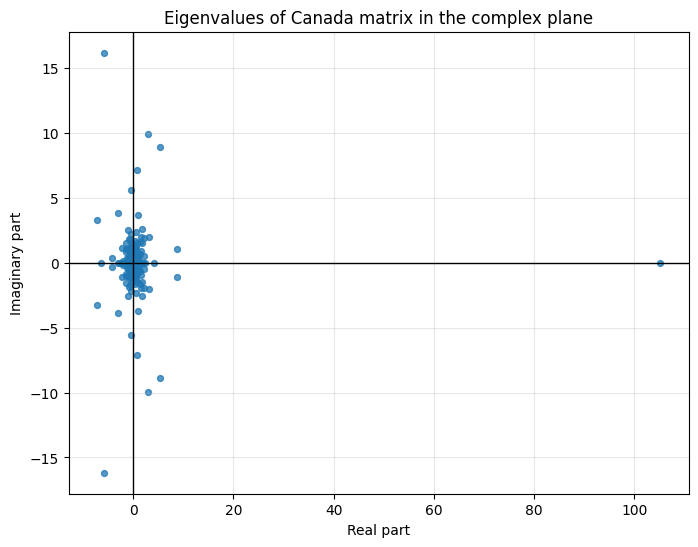

In [3]:
# Eigenvalues of the Canada binary matrix
A = canada_matrix.astype(float)
eigs = np.linalg.eigvals(A)

print(f"Number of eigenvalues: {eigs.size}")
print("First 10 eigenvalues:")
print(eigs[:10])

plt.figure(figsize=(8, 6))
plt.scatter(eigs.real, eigs.imag, s=18, alpha=0.75, color="tab:blue")
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title("Eigenvalues of Canada matrix in the complex plane")
plt.grid(True, alpha=0.3)
plt.show()

Number of contour samples: 1024
DC term magnitude: 0.000000


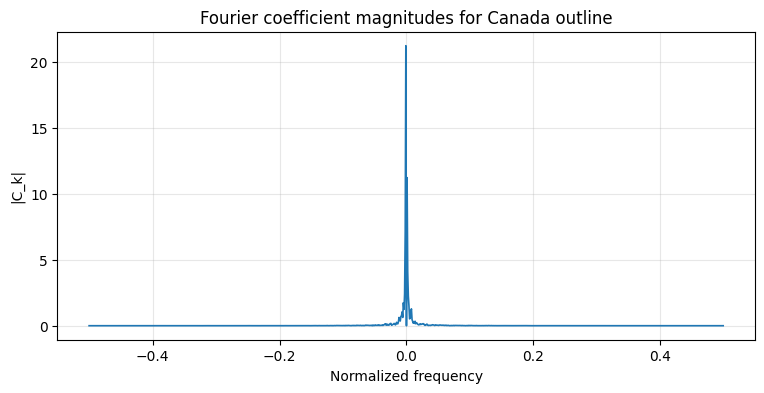

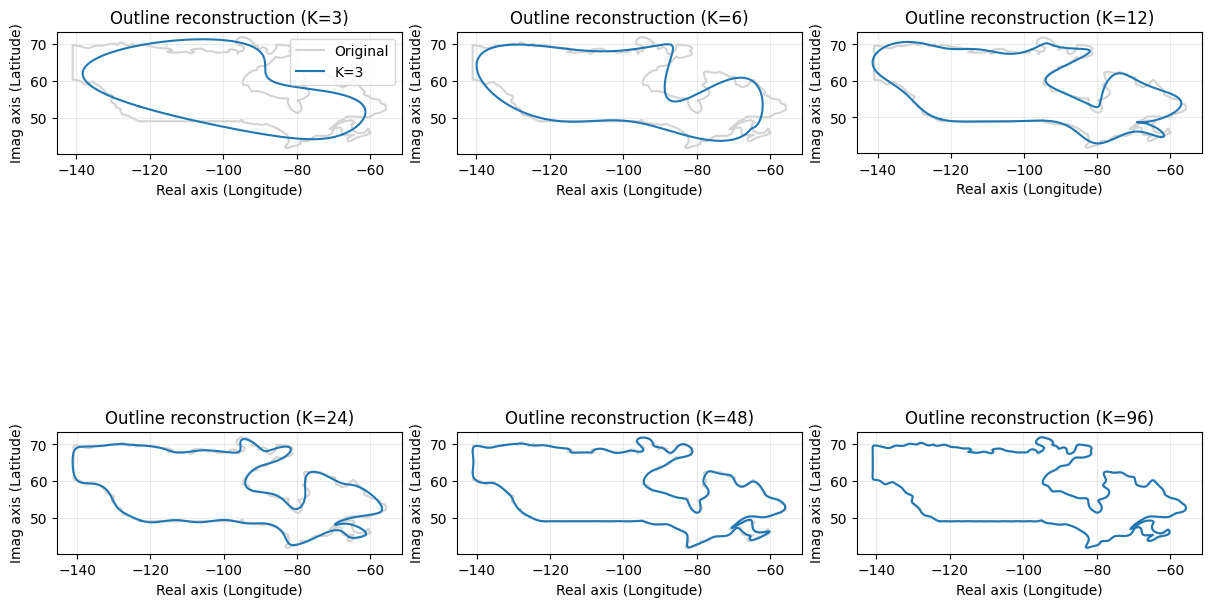

In [4]:
# Fourier decomposition of Canada's outline in the complex plane
geom = canada.geometry.iloc[0]
if geom.geom_type == "MultiPolygon":
    poly = max(geom.geoms, key=lambda g: g.area)
else:
    poly = geom

coords = np.array(poly.exterior.coords)
z_raw = coords[:, 0] + 1j * coords[:, 1]

# Arc-length resampling for near-uniform spacing
segment_lengths = np.abs(np.diff(z_raw))
arc = np.concatenate(([0.0], np.cumsum(segment_lengths)))
N = 1024
target_arc = np.linspace(0.0, arc[-1], N, endpoint=False)
x_u = np.interp(target_arc, arc, coords[:, 0])
y_u = np.interp(target_arc, arc, coords[:, 1])
z = x_u + 1j * y_u

# Center and compute Fourier coefficients
z_center = z - z.mean()
C = np.fft.fft(z_center) / N
freq = np.fft.fftfreq(N)

print(f"Number of contour samples: {N}")
print(f"DC term magnitude: {np.abs(C[0]):.6f}")

# Show coefficient magnitudes in frequency domain
plt.figure(figsize=(9, 4))
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(np.abs(C)), linewidth=1.2)
plt.title("Fourier coefficient magnitudes for Canada outline")
plt.xlabel("Normalized frequency")
plt.ylabel("|C_k|")
plt.grid(True, alpha=0.3)
plt.show()

# Reconstruct with increasing number of low-frequency pairs
k_values = [3, 6, 12, 24, 48, 96]
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

for ax, K in zip(axes.ravel(), k_values):
    Ck = np.zeros_like(C)
    Ck[0] = C[0]
    Ck[1:K+1] = C[1:K+1]
    Ck[-K:] = C[-K:]

    zk = np.fft.ifft(Ck * N) + z.mean()

    ax.plot(z.real, z.imag, color="lightgray", linewidth=1.5, label="Original")
    ax.plot(zk.real, zk.imag, color="tab:blue", linewidth=1.5, label=f"K={K}")
    ax.set_title(f"Outline reconstruction (K={K})")
    ax.set_aspect("equal")
    ax.set_xlabel("Real axis (Longitude)")
    ax.set_ylabel("Imag axis (Latitude)")
    ax.grid(True, alpha=0.25)

axes[0, 0].legend(loc="best")
plt.show()

In [5]:
# Movie: Fourier outline reconstruction with increasing harmonics K
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# If this cell is run independently, rebuild Fourier coefficients from the Canada outline
if "C" not in globals() or "z" not in globals() or "N" not in globals():
    geom = canada.geometry.iloc[0]
    if geom.geom_type == "MultiPolygon":
        poly = max(geom.geoms, key=lambda g: g.area)
    else:
        poly = geom

    coords = np.array(poly.exterior.coords)
    z_raw = coords[:, 0] + 1j * coords[:, 1]
    segment_lengths = np.abs(np.diff(z_raw))
    arc = np.concatenate(([0.0], np.cumsum(segment_lengths)))
    N = 1024
    target_arc = np.linspace(0.0, arc[-1], N, endpoint=False)
    x_u = np.interp(target_arc, arc, coords[:, 0])
    y_u = np.interp(target_arc, arc, coords[:, 1])
    z = x_u + 1j * y_u
    z_center = z - z.mean()
    C = np.fft.fft(z_center) / N

k_frames = np.unique(np.linspace(1, 128, 64, dtype=int))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
base_line, = ax.plot(z.real, z.imag, color="lightgray", linewidth=1.2, label="Original")
recon_line, = ax.plot([], [], color="tab:blue", linewidth=2.0, label="Fourier reconstruction")
ax.set_aspect("equal")
ax.set_xlabel("Real axis (Longitude)")
ax.set_ylabel("Imag axis (Latitude)")
ax.grid(True, alpha=0.25)
ax.legend(loc="best")
title = ax.set_title("Fourier outline movie (K=1)")

pad_x = 0.8
pad_y = 0.8
ax.set_xlim(z.real.min() - pad_x, z.real.max() + pad_x)
ax.set_ylim(z.imag.min() - pad_y, z.imag.max() + pad_y)

def update(frame_idx):
    K = int(k_frames[frame_idx])
    Ck = np.zeros_like(C)
    Ck[0] = C[0]
    Ck[1:K+1] = C[1:K+1]
    Ck[-K:] = C[-K:]
    zk = np.fft.ifft(Ck * N) + z.mean()
    recon_line.set_data(zk.real, zk.imag)
    title.set_text(f"Fourier outline movie (K={K})")
    return recon_line, title

ani = FuncAnimation(fig, update, frames=len(k_frames), interval=120, blit=False, repeat=True)
plt.close(fig)

HTML(ani.to_jshtml())